In [1]:
from mpl_toolkits.basemap import Basemap
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from collections import Counter
from bs4 import BeautifulSoup
from os.path import isfile
from pprint import pprint
import pandas as pd
import numpy as np
import matplotlib
import itertools
import requests
import operator
import json
import sys
import os

pd.options.display.float_format = '{:.4g}'.format

import warnings
warnings.filterwarnings('ignore')

import plotly.graph_objs as go
import plotly.offline as py
from plotly import tools

py.init_notebook_mode(connected=True)

In [2]:
# center = [59.9384, 30.3158] # palace square
# center = [52.523695, 13.417237] # alexanderplatz
# center = [55.7535, 37.62] # red square
# center = [41.393011, 2.161416] # barcelona
# center = [22.257328, 114.198523] # hong kong 

CITY = "hong_kong"
CITY_CENTER = [22.257328, 114.198523]
OPPOSITE_CITY = "moscow"

In [3]:
fn1 = "/Users/pavel/Sources/python/concepts/insta/cv_sandbox/photo_tagger/scenes_{}.json".format(CITY)
with open(fn1, "r") as f:
    data1 = json.load(f)

In [4]:
path = "/Users/pavel/Sources/python/concepts/insta/photos_{}/".format(CITY)
loc_file = list(map(lambda x: x.strip().split(","), open(path + "loc_info.csv", "r").readlines()[1:]))
id2loc = {x[0]: x[1] for x in loc_file}

In [5]:
def relevant_places(tag, n_top=100):
    d = {}
    for loc in list(data1.keys()):
        loc_val = 0
        for photo in data1[loc]:
            val = 0
            if tag in data1[loc][photo]['categories']:
                val = data1[loc][photo]['categories'][tag]
            loc_val += float(val)
        if loc_val > 0:
            d[loc] = loc_val
    return sorted(d.items(), key=operator.itemgetter(1), reverse=True)[:n_top]

### Areas & Streets

In [6]:
def area_normalize(s):
    stopword = "район"
    return s.replace(stopword, "").strip()


def street_normalize(s):
    return s.title()

# FIXME: multiple headers in adresses_city
fn = "/Users/pavel/Sources/python/concepts/insta/scripts/adresses_{}.csv".format(CITY)

AREA_COLUMN = 'suburb'
STREET_COLUMN = 'road'

geo_table = pd.read_csv(fn)
geo_table[AREA_COLUMN] = list(map(area_normalize, geo_table[AREA_COLUMN].tolist()))
geo_table[STREET_COLUMN] = list(map(street_normalize, geo_table[STREET_COLUMN].tolist()))

streets = geo_table[STREET_COLUMN].tolist()
areas = geo_table[AREA_COLUMN].tolist()

street_locations_n = sorted(Counter(streets).items(), 
                             key=operator.itemgetter(1), reverse=True)

area_locations_n = sorted(Counter(areas).items(), 
                           key=operator.itemgetter(1), reverse=True)
#

TOP_AREAS_N = 10
TOP_STREETS_N = 100
TOP_STREETS_VIS = 15

areas = [x[0] for x in area_locations_n[1:TOP_AREAS_N+1]] 
area_activity = [x[1] for x in area_locations_n[1:TOP_AREAS_N+1]]

streets = [x[0] for x in street_locations_n[1:TOP_STREETS_N+1]]
street_activity = [x[1] for x in street_locations_n[1:TOP_STREETS_N+1]]

In [13]:
N_TOP_AREAS = 5
HOLE = 0.5
PULL = 0.05
PIE_AREA_X = [0.1, 1.0]
PIE_AREA_Y = [0.15, 0.85]
BAR_CHART_OPACITY = 0.8
BAR_CHART_COLOR = 'red'
BAR_CHART_CM = "Wistia"
BAR_CHART_LEGEND_X = 0.55
BAR_CHART_LEGEND_Y = 0.0
# PERSONAL FIX
OTHER_LABEL = "Other"

colormap = matplotlib.cm.get_cmap(BAR_CHART_CM)
norm_val = np.linspace(1.0, 0.2, N_TOP_AREAS + 1)
pieces_colors = list(map(lambda x: matplotlib.colors.rgb2hex(colormap(x)), 
                         norm_val))

data = [go.Bar(y=streets[:TOP_STREETS_VIS], 
                x=street_activity[:TOP_STREETS_VIS],
                marker=dict(color='red'), 
                orientation='h', 
                opacity=BAR_CHART_OPACITY, 
                showlegend=False),
        
        go.Pie(values=area_activity[:N_TOP_AREAS]+[sum(area_activity[N_TOP_AREAS+1:])],
                labels=areas[:N_TOP_AREAS]+[OTHER_LABEL],
                domain=dict(x=PIE_AREA_X, y=PIE_AREA_Y),
                hoverinfo="label+percent+value",
                textinfo='label+value', 
               textposition = 'outside',
                hole=HOLE,
                sort=False,
                #showlegend=True,
                marker=dict(colors=pieces_colors), 
                pull=PULL
              )]

FONT_SIZE = 11
TICK_LEN = 4
PLOT_HEIGHT = 320
PLOT_WIDTH = 900
BAR_CHART_AREA_X = [0, 0.25]
BAR_CHART_AREA_Y = [0, 1.0]
MARGIN = go.layout.Margin(l=220, t=30, b=30, r=0)

layout = go.Layout(height=PLOT_HEIGHT, width=PLOT_WIDTH,
                   showlegend=False, 
                   margin=MARGIN, 
                   xaxis=dict(domain=BAR_CHART_AREA_X),
                   font=dict(size=FONT_SIZE, color='grey'),
                   yaxis=dict(domain=BAR_CHART_AREA_Y, 
                              autorange="reversed", 
                              ticklen=TICK_LEN)
                  )

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, show_link=False)

In [14]:
def get_street_coordinates(streets):
    request_template = "https://nominatim.openstreetmap.org/search.php?q={}&format=xml"
    street_coordinates = {}
    for x in streets:
        query = (x + " " + CITY).replace(" ", "+")
        request = requests.get(request_template.format(query))
        soup = BeautifulSoup(request.text, "lxml")
        place_tag = soup.find('place')
        # PERSONAL FIX
        if place_tag:
            street_coordinates[x] = [place_tag['lat'], place_tag['lon']]
        else:
            print("Error:", x)
            street_coordinates[x] = [0, 0]
    return street_coordinates


street_coordinates_fn = 'street_coordinates_{}.json'.format(CITY)
if isfile(street_coordinates_fn):
    with open(street_coordinates_fn, 'r') as f:
        street_coordinates = json.load(f)    
else:
    street_coordinates = get_street_coordinates(streets)
    with open(street_coordinates_fn, 'w') as outfile:
        json.dump(street_coordinates, outfile)

Error: 皇后大道東 Queen'S Road East
Error: 記利佐治街 Great George Street
Error: 黃泥涌道 Wong Nai Chung Road
Error: 科學館道 Science Museum Road
Error: 必列者士街 Bridges Street
Error: 浸會大學道 Baptist University Road


In [15]:
MAPBOX_TOKEN = os.environ['MAPBOX_TOKEN']
MARKER_SIZE = 17
MARKER_OPACITY = 0.4
MARKER_COLOR = 'red'
ZOOM = 12
MARGIN = dict(l=0, r=30, b=0, t=20)
MAP_WIDTH = 700
MAP_HEIGHT = 400
MAX_MARKER_SIZE = 35

lat = [x[0] for x in street_coordinates.values()]
lon = [x[1] for x in street_coordinates.values()]
marker_sizes = [x if x < MAX_MARKER_SIZE else MAX_MARKER_SIZE for x in street_activity]

data = [go.Scattermapbox(
            lat=lat,
            lon=lon,
            mode='markers',
            marker=dict(
                size=marker_sizes,
                color=MARKER_COLOR,
                opacity=MARKER_OPACITY
            ),
            text=streets,
            hoverinfo='text')]

layout = go.Layout(
            width = MAP_WIDTH,
            height = MAP_HEIGHT,
            hovermode='closest',
            margin=MARGIN,
            mapbox=dict(
                accesstoken=MAPBOX_TOKEN,
                center=dict(
                    lat=CITY_CENTER[0],
                    lon=CITY_CENTER[1]
                ),
                zoom=ZOOM,
                style='light'
            ))

fig = dict(data=data, layout=layout)
py.iplot(fig, show_link=False)

In [16]:
N_SCENES = 25
SELECTED_TAGS = ['library/indoor', 'restaurant', 'street', 'bar', 
                 'discotheque', 'promenade', 'museum/indoor', 'art_gallery', 
                 'bridge', 'dressing_room', 'picnic_area', 'beer_hall', 
                 'skyscraper', 'bookstore', 'closet', 'television_studio', 
                 'stadium/soccer', 'pub/indoor', 'industrial_area', 'art_studio',
                 'lawn', 'highway', 'coffee_shop', 'booth/indoor', 'martial_arts_gym']

def get_tags(mode, top_scenes=None):
    if mode == "top":
        return [x[0] for x in top_scenes]
    elif mode == "selected":
        return SELECTED_TAGS
    
def trim(s, max_len=20):
    if len(s) <= max_len:
        return s
    else:
        s = s[:max_len].strip("_")
        return s + "..."

In [17]:
def calculate_street_enviroment():
    locations_env = []
    for loc in list(data1.keys()):
        photo_env = []
        for photo in data1[loc]:
            photo_env.append(data1[loc][photo]['enviroment'])
            
        env_counter = dict(Counter(photo_env))
        
        street = geo_table[geo_table['id'] == int(loc)][STREET_COLUMN].tolist()
        
        if 'outdoor' in env_counter:
            outdoor_cn = env_counter['outdoor']
        else:
            outdoor_cn = 0
            
        if 'indoor' in env_counter:
            indoor_cn = env_counter['indoor']
        else:
            indoor_cn = 0
        
        if street and street[0] != 'None':
            locations_env.append([loc, outdoor_cn, 
                                  indoor_cn, 
                                  street[0]])
    locations_env = pd.DataFrame(locations_env)
    locations_env.columns = ['id', 'outdoor', 'indoor', 'street']
    return locations_env


def load_json(fn):
    with open(fn, "r") as f:
        return json.load(f)


def build_tags_table(tags, scene_data):
    dd = []
    for loc in list(scene_data.keys()):
        cn = Counter()
        location_data = scene_data[loc]
        for photo in location_data:
            photo_data = scene_data[loc][photo]['categories'].items()
            for category, val in photo_data:
                cn[category] += float(val) / len(location_data)
        dd.append([loc, cn])

    dd1 = []
    for x in dd:
        dd1.append([x[0]] + [x[1][tag] for tag in tags])

    tags_table = pd.DataFrame(dd1)
    tags_table.columns=["id"] + tags
    
    return tags_table

In [19]:
ENV_TIME_N_TICKS = 40

####

locations_env = calculate_street_enviroment()

env_data = {}
for street in locations_env['street'].unique():
    outdoor_cn = locations_env[locations_env['street'] == street]['outdoor'].sum()
    indoor_cn = locations_env[locations_env['street'] == street]['indoor'].sum()
    
    env_data[street] = [outdoor_cn, indoor_cn]
    
####

street_outdoor_data, street_indoor_data = [], []
for x in streets:
    # PERSONAL FIX
    if x in env_data:
        street_outdoor_data.append(env_data[x][0])
        street_indoor_data.append(env_data[x][1])
    
####

street_outdoor_data = np.array(street_outdoor_data)
street_indoor_data = np.array(street_indoor_data)

outdoor_rate = street_outdoor_data / (street_indoor_data + street_outdoor_data)

####

cn = Counter()
for loc in list(data1.keys()):
    for photo in data1[loc]:
        for category, val in data1[loc][photo]['categories'].items():
            cn[category] += float(val)
            
all_tags = list(cn.keys())
forbidden_tags = ["beauty_salon", "dressing_room"]
for x in forbidden_tags:
    all_tags.remove(x)

####

scenes_fn = "/Users/pavel/Sources/python/concepts/insta/cv_sandbox/photo_tagger/scenes_{}.json"

selected_tags = get_tags('selected')

opposite_scenes = load_json(scenes_fn.format(OPPOSITE_CITY))
target_scenes = load_json(scenes_fn.format(CITY))

opposite_tags_table = build_tags_table(all_tags, opposite_scenes)
target_tags_table = build_tags_table(all_tags, target_scenes)

general_tags_table = np.vstack((target_tags_table[all_tags].values.tolist(), 
                                opposite_tags_table[all_tags].values.tolist()))

target_scenes = load_json(scenes_fn.format(CITY))
target_tags_table = build_tags_table(all_tags, target_scenes)

####

night_tags = ['bar', 'discotheque', 'beer_hall', 'pub/indoor', 'restaurant']
day_tags = [x for x in SELECTED_TAGS if not x in night_tags and \
                                        not x in forbidden_tags]

####

daily_activity_list = []
for loc in list(data1.keys()):
    row = target_tags_table[target_tags_table['id'] == loc]
    day_val = row[day_tags].values.sum()
    night_val = row[night_tags].values.sum()
    if loc in id2loc:
        street = geo_table[geo_table['id'] == int(loc)][STREET_COLUMN].tolist()
        if street and street[0] != 'None':
            daily_activity_list.append([loc, day_val, night_val, street[0]])
        
daily_activity_table = pd.DataFrame(daily_activity_list)
daily_activity_table.columns = ['id', 'day', 'night', 'street']

####

daily_activity_dict = {}
for street in locations_env['street'].unique():
    day_cn = daily_activity_table[daily_activity_table['street'] == street]['day'].values.sum()
    night_cn = daily_activity_table[daily_activity_table['street'] == street]['night'].values.sum()
    
    daily_activity_dict[street] = [day_cn, night_cn]
    
####

street_day_activity, street_night_activity = [], []
for x in streets:
    if x in daily_activity_dict:
        street_day_activity.append(daily_activity_dict[x][0])
        street_night_activity.append(daily_activity_dict[x][1])
        
####

street_ticks = np.array(streets)

street_day_activity = np.array(street_day_activity)
street_night_activity = np.array(street_night_activity)

day_activity_rate = np.array(street_day_activity / 
                             (street_day_activity + street_night_activity))

VERTICAL_SPACING = 0.09
fig = tools.make_subplots(rows=2, cols=1,
                          vertical_spacing=VERTICAL_SPACING,
                          print_grid=False)

ENV_COLOR = 'red'
INDOOR_OPACITY = 0.5

outdoor_trace = go.Bar(
    y=outdoor_rate[:ENV_TIME_N_TICKS],
    x=street_ticks[:ENV_TIME_N_TICKS],
    marker=dict(color=ENV_COLOR), 
    name="outdoor rate",
    legendgroup='group1'
)

indoor_trace = go.Bar(
    y=1-outdoor_rate[:ENV_TIME_N_TICKS],
    x=street_ticks[:ENV_TIME_N_TICKS],
    marker=dict(color=ENV_COLOR), 
    opacity=INDOOR_OPACITY,
    name="indoor rate",
    legendgroup='group1'
)

fig.append_trace(outdoor_trace, 1, 1)
fig.append_trace(indoor_trace, 1, 1)

DAILY_COLOR = 'dodgerblue'
NIGHT_OPACITY = 0.5

day_trace = go.Bar(y=day_activity_rate[:ENV_TIME_N_TICKS],
                   x=street_ticks[:ENV_TIME_N_TICKS],
                   marker=dict(color=DAILY_COLOR), 
                   name="day rate",
                   legendgroup='group2')

night_trace = go.Bar(y=1-day_activity_rate[:ENV_TIME_N_TICKS],
                     x=street_ticks[:ENV_TIME_N_TICKS],
                     marker=dict(color=DAILY_COLOR), 
                     opacity=NIGHT_OPACITY,
                     name="night rate",
                     legendgroup='group2')

fig.append_trace(day_trace, 2, 1)
fig.append_trace(night_trace, 2, 1)

MARGIN = go.layout.Margin(t=30, b=150, l=20)
FONTSIZE = 11
FONTCOLOR = 'lightgrey'
PLOT_HEIGHT = 350
PLOT_WIDTH = 760
LEGEND_X = 1.01
LEGEND_Y = 0.5

fig['layout'].update(width=PLOT_WIDTH, height=PLOT_HEIGHT,
                     legend=dict(x=LEGEND_X, y=LEGEND_Y), 
                     barmode='stack', margin=MARGIN,
                     xaxis1=dict(showticklabels=False),
                     xaxis2=dict(tickangle=-90, 
                                 tickfont=dict(size=FONTSIZE, color=FONTCOLOR)))

py.iplot(fig, show_link=False)

### Tags

In [20]:
fig = tools.make_subplots(rows=1, cols=2, print_grid=False, horizontal_spacing = 0.08,
                          vertical_spacing = 0.15)

cn = Counter()
for loc in list(data1.keys()):
    for photo in data1[loc]:
        for category, val in data1[loc][photo]['categories'].items():
            cn[category] += float(val)

top_scenes = sorted(cn.items(), key=operator.itemgetter(1), reverse=True)[:N_SCENES]

tags = get_tags('selected', top_scenes)
scenes_result = sorted([[x, cn[x]] for x in tags], key=lambda x: x[1], reverse=True)

N_SKIP = 0
MAX_HOVER_LEN = 25

top_places = [relevant_places(key, 5) for key, _ in scenes_result][N_SKIP:]
id_list_to_name = lambda x: [trim(id2loc[y[0]], MAX_HOVER_LEN) for y in x]



fig.append_trace(go.Bar(
            x=[x[0].split("/")[0] for x in scenes_result][N_SKIP:],
            y=[x[1] for x in scenes_result][N_SKIP:],
            marker = dict(color='deeppink'),
            text=[" <br>".join(id_list_to_name(x)) for x in top_places],
            hoverinfo="y+text",
    ), 1,1)
##########

fn3 = "/Users/pavel/Sources/python/concepts/insta/cv_sandbox/photo_tagger/scenes_{}.json".format(OPPOSITE_CITY)
with open(fn3, "r") as f:
    data3 = json.load(f)
    
cn = Counter()
for loc in list(data3.keys()):
    for photo in data3[loc]:
        for category, val in data3[loc][photo]['categories'].items():
            cn[category] += float(val)

scenes_result2 = sorted(cn.items(), key=operator.itemgetter(1), reverse=True)

d1 = {x[0]: x[1]/len(data1) for x in scenes_result}
d2 = {x[0]: x[1]/len(data3) for x in scenes_result2}

sc_delta_val = []
for x in d1:
    if x in d1 and x in d2:
        sc_delta_val.append([x, d1[x]-d2[x]])
    else:
        print("error", x, x in d1, x in d2)

sc_tags = [z[0] for z in sorted(scenes_result, key=lambda x: x[0])]

sc_delta = sorted(sc_delta_val, key=lambda x: abs(x[1]), reverse=True)[:25]
sc_delta = sorted(sc_delta, key=lambda x: x[1], reverse=False)

fig.append_trace(go.Bar(
            x=[x[0] for x in sc_delta],
            y=[x[1] for x in sc_delta],
            marker = dict(color='mediumseagreen')
    ),1,2)

FONT_SIZE = 11
fig['layout'].update(height=330, width=770,
                     yaxis1=dict(tickfont=dict(size=FONT_SIZE, color='lightgrey')),
                     yaxis2=dict(tickfont=dict(size=FONT_SIZE, color='lightgrey')),
                     xaxis1=dict(tickfont=dict(size=FONT_SIZE, color='lightgrey'), tickangle=-90),
                     xaxis2=dict(tickfont=dict(size=FONT_SIZE, color='lightgrey'), tickangle=-90),
                     margin=go.layout.Margin(t=30, b=120, l=25, r=25), showlegend=False)

py.iplot(fig, show_link=False)

In [21]:
sorted_tags = [x[0] for x in scenes_result]

def build_tags_table():
    dd = []
    for loc in list(data1.keys()):
        cn = Counter()
        for photo in data1[loc]:
            for category, val in data1[loc][photo]['categories'].items():
                cn[category] += float(val)
        dd.append([loc, cn])

    dd1 = []
    for x in dd:
        dd1.append([x[0]] + [x[1][tag] for tag in tags])

    tags_table = pd.DataFrame(dd1)
    tags_table.columns=["id"] + tags
    
    return tags_table


def calculate_street_vectors():
    keywords_table = build_tags_table()
    street_vectors = []
    for s in streets[:TOP_STREETS_VIS]:
        sv = np.zeros(N_SCENES)
        locations_id = geo_table[geo_table[STREET_COLUMN]==s]['id'].astype(str)
        for loc in locations_id:
            if loc in keywords_table.id.values:
                is_relevant = keywords_table['id']==loc
                relevant_row = keywords_table[is_relevant][sorted_tags]
                location_vector = relevant_row.iloc[0].tolist()
                sv += location_vector

        street_vectors.append(sv)
    
    return np.array(street_vectors)

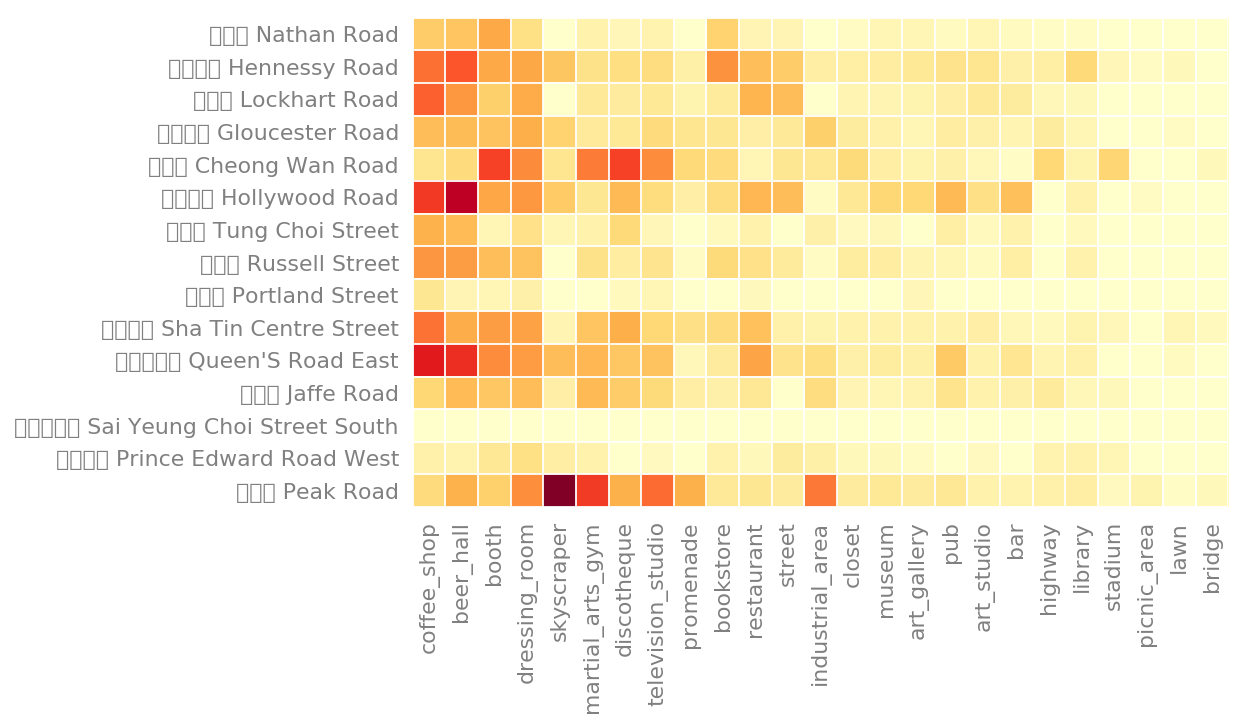

In [22]:
FONT_SIZE = 11
MAX_IM_VALUE = 7 # 20
COLORMAP = 'YlOrRd'
LABEL_COLOR = 'grey'
GRID_COLOR = 'white'
GRID_WIDTH = 0.9
PLT_WIDTH = 8.5
PLT_HEIGHT = 4.5

plt.figure(figsize=(PLT_WIDTH, PLT_HEIGHT))

labels = [x.split("/")[0] for x in sorted_tags]

street_vectors = calculate_street_vectors()
im = plt.imshow(street_vectors**0.5, cmap=COLORMAP, vmax=MAX_IM_VALUE)

ax = plt.gca()
ax.set_xticks(np.arange(-0.5, N_SCENES, 1), minor=True)
ax.set_yticks(np.arange(-0.5, TOP_STREETS_VIS, 1), minor=True)

ax.tick_params(width=0)
ax.tick_params(which="minor", width=0)

for side in ['top', 'right', 'bottom', 'left']:
    ax.spines[side].set_visible(False)

plt.grid(which="minor", color=GRID_COLOR, linestyle='-', linewidth=GRID_WIDTH)

plt.xticks(range(N_SCENES), labels, rotation=90, size=FONT_SIZE, color=LABEL_COLOR)
plt.yticks(range(TOP_STREETS_VIS), streets[:TOP_STREETS_VIS], size=FONT_SIZE, color=LABEL_COLOR);

In [23]:
cn = Counter()
for loc in list(data1.keys()):
    for photo in data1[loc]:
        for category, val in data1[loc][photo]['categories'].items():
            cn[category] += float(val)
            
all_tags = list(cn.keys())

all_tags.remove("beauty_salon")
all_tags.remove("dressing_room")

####

scenes_fn = "/Users/pavel/Sources/python/concepts/insta/cv_sandbox/photo_tagger/scenes_{}.json"


def load_json(fn):
    with open(fn, "r") as f:
        return json.load(f)


def build_tags_table(tags, scene_data):
    dd = []
    for loc in list(scene_data.keys()):
        cn = Counter()
        location_data = scene_data[loc]
        for photo in location_data:
            photo_data = scene_data[loc][photo]['categories'].items()
            for category, val in photo_data:
                cn[category] += float(val) / len(location_data)
        dd.append([loc, cn])

    dd1 = []
    for x in dd:
        dd1.append([x[0]] + [x[1][tag] for tag in tags])

    tags_table = pd.DataFrame(dd1)
    tags_table.columns=["id"] + tags
    
    return tags_table


selected_tags = get_tags('selected')

opposite_scenes = load_json(scenes_fn.format(OPPOSITE_CITY))
target_scenes = load_json(scenes_fn.format(CITY))

opposite_tags_table = build_tags_table(all_tags, opposite_scenes)
target_tags_table = build_tags_table(all_tags, target_scenes)

general_tags_table = np.vstack((target_tags_table[all_tags].values.tolist(), 
                                opposite_tags_table[all_tags].values.tolist()))

####

visual_data = TSNE().fit_transform(general_tags_table).T

####

target_path = "/Users/pavel/Sources/python/concepts/insta/photos_{}/".format(CITY)
opposite_path = "/Users/pavel/Sources/python/concepts/insta/photos_{}/".format(OPPOSITE_CITY)

loc_file_target = list(map(lambda x: x.strip().split(","), open(target_path + "loc_info.csv", "r").readlines()[1:]))
id2loc_target = {x[0]: x[1] for x in loc_file_target}

loc_file_opposite = list(map(lambda x: x.strip().split(","), open(opposite_path + "loc_info.csv", "r").readlines()[1:]))
id2loc_opposite = {x[0]: x[1] for x in loc_file_opposite}

labels_opposite = [id2loc_opposite[x] if x in id2loc_opposite else "_" for x in opposite_tags_table['id'].tolist() ]
labels_target = [id2loc_target[x] if x in id2loc_target else "_"  for x in target_tags_table['id'].tolist()]

####

id2city = {}

for x in opposite_tags_table['id'].tolist():
    id2city[x] = OPPOSITE_CITY
    
for x in target_tags_table['id'].tolist():
    id2city[x] = CITY
    
####

def closest_node(node, nodes):
    nodes = np.asarray(nodes)
    dist_2 = np.sum((nodes - node)**2, axis=1)
    return np.argsort(dist_2)

vis_list = list(visual_data.T)
all_ids = target_tags_table['id'].tolist() + opposite_tags_table['id'].tolist()
s = []

indexes_target,indexes_opposite,indexes_other = [], [], []
for j in range(len(visual_data[0])):
    xc, yc = visual_data[0, j], visual_data[1, j]
    
    f_v = vis_list[:j]+vis_list[j+1:]
    cn = closest_node((xc, yc), f_v)[:10]

    curr_city = id2city[all_ids[j]]
    nb = [id2city[all_ids[x]] for x in cn]
    if nb.count(curr_city) / len(nb) > 0.7:
        if curr_city == CITY:
            indexes_target.append(j)
        elif curr_city == OPPOSITE_CITY:   
            indexes_opposite.append(j)
    else:   
        indexes_other.append(j)

###

colors = np.array(['dodgerblue'] * target_tags_table.shape[0] + 
                  ['red'] * opposite_tags_table.shape[0])

for j in indexes_other:
    colors[j] = 'aliceblue'

labels = np.array(labels_target + labels_opposite)

####

def create_scatter(x, y, colors, labels, name):
    return go.Scatter(x=x, y=y,
                      mode='markers',
                      hoverinfo='text',
                      text=labels,
                      name=name,
                      marker=dict(opacity=MARKER_OPACITY, 
                                   color=colors))
####

MARKER_OPACITY = 0.4

data = [create_scatter(np.array(visual_data[0])[indexes_target],
                       np.array(visual_data[1])[indexes_target],
                       colors[indexes_target], labels[indexes_target],
                       CITY),
        create_scatter(np.array(visual_data[0])[indexes_opposite],
                       np.array(visual_data[1])[indexes_opposite],
                       colors[indexes_opposite], labels[indexes_opposite],
                       OPPOSITE_CITY),
        # for debug
        #create_scatter(np.array(visual_data[0])[indexes_other],
        #               np.array(visual_data[1])[indexes_other],
        #               colors[indexes_other], labels[indexes_other],
        #               "other")
       ]

MARGIN = dict(l=0, r=30, b=0, t=20)
PLOT_HEIGHT = 400
PLOT_WIDTH = 500

axis_style = dict(showticklabels=False, zeroline=False)
layout = go.Layout(height=PLOT_HEIGHT, width=PLOT_WIDTH,
                    margin=MARGIN, hovermode='closest',
                    xaxis=axis_style, yaxis=axis_style)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, show_link=False)